In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [2]:
lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
config = {'sca': 1,
          'sca_position': (2048, 2048)}

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


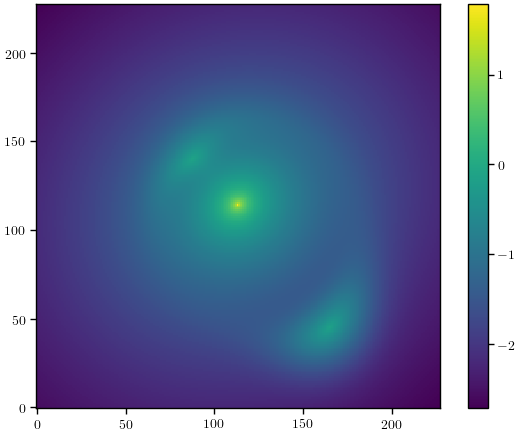

In [3]:
synth = SyntheticImage(lens, roman, band=band, arcsec=scene_size, oversample=oversample, **config)

plt.imshow(np.log10(synth.image))
plt.colorbar()
plt.show()

In [4]:
print(synth.pixel_scale)
print(synth.num_pix)
print(synth.arcsec)
print(synth.image.shape)

0.022
228
5.016
(228, 228)


In [5]:
print(synth.num_pix / synth.oversample)

45.6


Loading cached PSF: /nfshome/bwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl


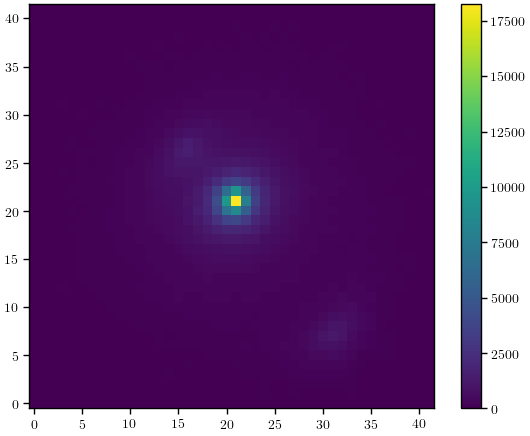

In [32]:
exposure = Exposure(synth, exposure_time=146, **config)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()

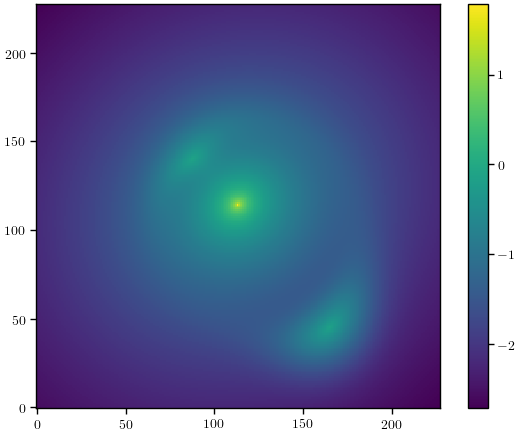

In [31]:
zp = roman.get_zeropoint_magnitude(band, config['sca'])
array = lens.get_array(num_pix=228, side=5.016, band=band, zp=zp)

plt.imshow(np.log10(array))
plt.colorbar()
plt.show()

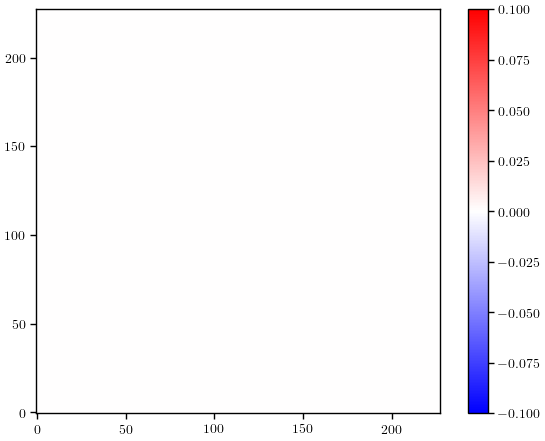

In [15]:
plt.imshow(synth.image - array, cmap='bwr')
plt.colorbar()
plt.show()

assert synth.image.all() == array.all()

In [35]:
gs_results, _ = gs.get_images(lens, [array], [band], roman.zp_dict['SCA01'], input_size=51, output_size=42, grid_oversample=oversample, psf_oversample=5, detector=config['sca'], detector_pos=config['sca_position'], exposure_time=146, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', validate=False)
gs_image = gs_results[0] * 146

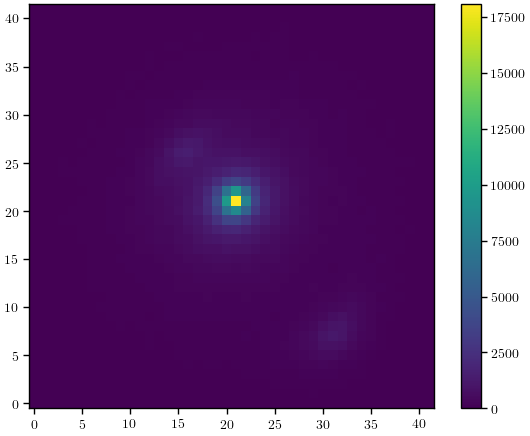

In [36]:
plt.imshow(gs_image)
plt.colorbar()
plt.show()

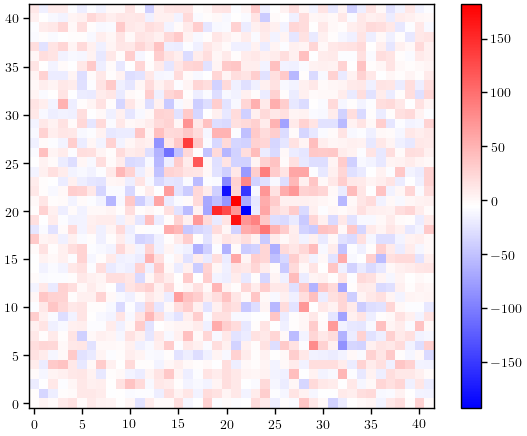

In [38]:
plt.imshow(exposure.exposure - gs_image, cmap='bwr')
plt.colorbar()
plt.show()